<a href="https://colab.research.google.com/github/Alonment/CSCI4962-Projects-In-ML-AI/blob/main/CSCI4962_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Problem Statement: Classify a given image of a number (0-9).

Dataset - https://www.kaggle.com/c/digit-recognizer/data


**Task 1(25 points)**: Assuming you are not familiar with the framework, in this part of the homework you will present your research describing the resources you used to learn the framework (must include links to all resources). Clearly explain why you needed a particular resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of all the computations in a NN i.e., what libraries/tools do you need within this framework.)


The framework I decided to explore and learn more about is Tensorflow. Given that I have zero experience with any ML/AI framework, the various beginner tutorials available both on Tensorflow's website and other sources such as Medium or Youtube were valuable resources as I acquanted myself with what features and capabilities Tensorflow provided. Furthermore, the video snippet (link below) gave me a unique perspective of what neural networks were in context with what structures and operations existed in Tensorflow itself.


---


Just to reinforce the topics discussed during lecture, I reviewed basic NN architecture and ideas through this rather detailed and precise youtube video (https://www.youtube.com/watch?v=tPYj3fFJGjk) [2:45 ~ 3:35]. Furthermore, the beginner and advanced tutorials available on Tensorflow's website (https://www.tensorflow.org/overview) proved to be valuable resources as I quickly gained insight into what operations and classes tensorflow provided in regards to their built in layers, activation functions, optimizers, etc.


---

In regards to the actual architecture that Tensorflow implements, Keras appears to be the standard. Thus, https://www.tensorflow.org/guide/intro_to_modules#keras_models_and_layers helped in my understanding of what exactly a tensorflow layer is composed of as well as what possible layers existed and how they interacted with one another (i.e. Dense layers, Feature layers, etc.). All of this information was invaluable in actually utlizing Tensorflow and all of its operations/capabilites properly.

**Task 2 (60 points)**: Once you have figured the resources you need for the project, design, and implement your project. The project must include the following steps (it's not limited to these steps):

  1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
  2. Perform a train-dev-test split.
  3. Implement forward propagation (clearly describe the activation functions and other hyper-parameters you are using).
  4. Compute the final cost function.
  5. Implement mini-batch gradient descent to train your model. In this step it is up to you as someone in charge of their project to improvise using optimzation algorithms (Adams, RMSProp etc.) and/or regularization.
  6. Present the results using the test set.

**Exploratory Data Analysis**


---

Since the MNIST handwritten digit dataset is rather well-known and commonly used when individuals begin their image classification journey, it's more likely than not that the data is already thoroughly cleaned and proper. Nonetheless, we continue with our EDA.



In [ ]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

#Load dataset
df_train = pd.read_csv("drive/MyDrive/csci4962_hw3_train.csv")

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.nunique()

label       10
pixel0       1
pixel1       1
pixel2       1
pixel3       1
            ..
pixel779     3
pixel780     1
pixel781     1
pixel782     1
pixel783     1
Length: 785, dtype: int64

In [ ]:
print(f"Shape of Training Set: {df_train.shape}\n")
print(f"{df_train.info(null_counts=True)}\n")
print(df_train.isna)

Shape of Training Set: (42000, 785)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

<bound method DataFrame.isna of        label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0          1       0       0       0  ...         0         0         0         0
1          0       0       0       0  ...         0         0         0         0
2          1       0       0       0  ...         0         0         0         0
3          4       0       0       0  ...         0         0         0         0
4          0       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
41995      0       0       0       0  ...         0         0         0         0
41996      1       0       0       0  ...         0         0         0         0
41997      7       0       0 

Given all this, we seem to have a significantly large training set with many clean, uniform training examples to train on. It is also clear that there are no NaN nor empty values, therefore making our data preprocessing lives much, much easier. Now, all there's left to do is to actually examine and visualize what a single training example looks like.

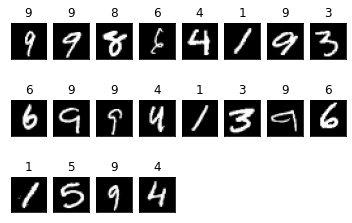

In [ ]:
# Display a random selection of 20 digits from the training set

indexes = np.random.randint(0, 42000, 20)
images = df_train.iloc[indexes, :]

labels = images["label"].to_numpy()
pixels = images.drop(columns=["label"]).to_numpy()

for i in range(20):
  plt.subplot((20//8)+1, 8, i+1)
  plot = pixels[i].reshape((28,28))
  plt.imshow(plot, cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title(labels[i])

plt.show()

Exactly as expected, every single image is rather well-defined for the most part, with their pixel values resembling each digit precisely.

**Train-Dev-Test Split**


---
In order to do this, we can simply split our training set twice; once for the dev set, and another for the test set. In order to make the most out of Tensorflow's architecture (along with the fact that this data set was loaded from kaggle rather than tensorflow itself), we must convert these sets into their respective tf.data.Dataset versions.


In [ ]:
from sklearn.model_selection import train_test_split

# Converts a pandas dataframe into a tensorflow dataset
def convert_to_tfds(dataframe):
  labels = dataframe.pop("label")
  dataframe = dataframe / 255
  dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  dataset = dataset.shuffle(buffer_size=len(dataframe), seed=0)
  return dataset.batch(64) # Ensures that the model is optimized with mini batch gd

training_set = df_train.copy()

# Split training set into dev and test sets respectively
train, dev = train_test_split(training_set, test_size=0.1, random_state = 0)
train, test = train_test_split(train, test_size = 0.1, random_state = 0)

ds_train = convert_to_tfds(train)
ds_dev = convert_to_tfds(dev)
ds_test = convert_to_tfds(test)

**Model Implementation**

In [ ]:
# Store features in order to create input layer
columns = list(training_set.columns)[1:]
features = [tf.feature_column.numeric_column(feature) for feature in columns]

# Define our feed-foward neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(features), # Input layer with 784 neurons for each pixel
    tf.keras.layers.Dense(128, activation="relu"), # 1st Hidden Layer with relu activation
    tf.keras.layers.Dense(128, activation="relu"), # 2nd Hidden Layer with relu activation
    tf.keras.layers.Dense(10, activation="softmax") # Output layer with 10 neurons (1 for each 0-9 digit)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Experimenting with different optimizers such as RMSprop, SGD, etc., Adam appeared as to be the best in regards to convergence speed as well as overall average training time and resulting accuracy.

In [247]:
model.fit(ds_train, validation_data=ds_dev, epochs=4)

Epoch 1/4
532/532 [==============================] - 56s 61ms/step - loss: 0.3393 - accuracy: 0.9023 - val_loss: 0.1893 - val_accuracy: 0.9450
Epoch 2/4
532/532 [==============================] - 30s 43ms/step - loss: 0.1371 - accuracy: 0.9587 - val_loss: 0.1468 - val_accuracy: 0.9564
Epoch 3/4
532/532 [==============================] - 31s 46ms/step - loss: 0.0944 - accuracy: 0.9712 - val_loss: 0.1289 - val_accuracy: 0.9631
Epoch 4/4
532/532 [==============================] - 32s 47ms/step - loss: 0.0716 - accuracy: 0.9781 - val_loss: 0.1185 - val_accuracy: 0.9657


Note that Tensorflow's implementation of gradient descent (as above) is essentially Mini-Batch GD since we converted our train, dev, test sets to tensorflow datasets with batch size specified.

In [248]:
# Evaluating the model's performance
test_loss, test_acc = model.evaluate(ds_test, verbose=1) 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

60/60 [==============================] - 3s 35ms/step - loss: 0.0904 - accuracy: 0.9751
Test loss: 0.09037420153617859
Test accuracy: 0.9751322865486145


Overall, Tensorflow proved to be quite a powerful tool/framework in regards to actually implementing this neural network as well as training and testing it, with an ultimate test set accuracy of **97.51** being achieved.

**Task 3 (15 points):** In task 2 describe how you selected the hyperparameters. What was the rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use an optimization algorithm? Why or why not?

Regarding the hyperparameters I chose, I began by simply testing out various combinations (batch_size: 32, 64, 128; epochs: 2, 4, 10; num_neurons: 32, 64, 128; etc.). Ultimately, I arrived at a relatively large batch-size that provided a fair convergence speed along with decent accuracy, a small epoch size to decrease the likelihood of overfitting, and 128 neurons so that our rather large input set could be properly handled and fitted accordingly. With this combination of hyperparameters, the model appeared to perform much more consistently with fairly high accuracy when attempting to generalize outside of the training set.

The optimization algorithm I ultimately decided to utilize is Adam. Out of all the optimizers that I tested the model with, Adam provided the most consistent convergence, high accuracies, and greatly decreasing losses per epoch. Furthermore, some research into the various algorithms also confirmed my findings as there appears to wide-ranging support of Adam for many of the same reasons in visual learning.

Given that the model still achieved fairly high accuracy outside of our training data ($\geq .975$ accuracy) and the rather tedious care placed in tuning the hyperparameters, I didn't feel it necessary to implement regularization. However, I'm sure that implementing it could improve our model's ability to generalize even more, perhaps reaching as far as the $\geq .99$ accuracy range.